In [1]:
import json
import struct
import numpy as np
import matplotlib.pyplot as plt
import photonforge as pf
import siepic_forge as siepic
import luxtelligence_lnoi400_forge as lxt
import tidy3d as td

td.config.logging_level = "ERROR"

# Set up technologies
siepic_tech = siepic.ebeam()
basic_tech = pf.basic_technology()
lxt_tech = lxt.lnoi400()
pf.config.default_technology = siepic_tech

# Initialize live viewer for real-time visualization
from photonforge.live_viewer import LiveViewer
viewer = LiveViewer()

# Define simulation parameters
wavelengths = np.linspace(1.53, 1.57, 101)
freqs = pf.C_0 / wavelengths

LiveViewer started at http://localhost:58850


In [2]:
class ThermalModel(pf.Model):
    def __init__(self, n_complex, voltage=0, coefficient=3e-4):
        super().__init__(
            n_complex=n_complex,
            voltage=voltage,
            coefficient=coefficient,
        )
        self.n_complex = np.array(n_complex, ndmin=2)
        self.voltage = voltage
        self.coefficient = coefficient

    def __copy__(self):
        return ThermalModel(self.n_complex, self.voltage, self.coefficient)

    def __deepcopy__(self, memo=None):
        # n_complex is an array, so we want to make sure to create a deep copy of it.
        # Other values (voltage and coefficient) are immutable (floats), so we can use them directly.
        return ThermalModel(self.n_complex.copy(), self.voltage, self.coefficient)

    def __repr__(self):
        return f"ThermalModel({self.n_complex!r}, {self.voltage!r}, {self.coefficient!r})"

    def __str__(self):
        return f"ThermalModel at {self.voltage} V"

    @property
    def as_bytes(self):
        coeffs = struct.pack("<2d", self.voltage, self.coefficient)
        shape = struct.pack("<2l", *self.n_complex.shape)
        n_data = self.n_complex.astype(complex).tobytes()
        # Add version 0 as first byte
        return b"\x00" + coeffs + shape + n_data

    @classmethod
    def from_bytes(cls, byte_repr):
        version = byte_repr[0]
        if version != 0:
            raise RuntimeError(f"Incompatible version for ThermalModel: {version}")

        byte_repr = byte_repr[1:]
        fmt = "<2d2l"
        head_len = struct.calcsize(fmt)
        voltage, coefficient, rows, cols = struct.unpack(fmt, byte_repr[:head_len])

        byte_repr = byte_repr[head_len:]
        n_complex = np.frombuffer(byte_repr, dtype=complex).reshape((rows, cols))

        return cls(n_complex, voltage, coefficient)

    @pf.cache_s_matrix
    def start(self, component, frequencies, voltage=None, **kwargs):
        # Allow overriding voltage as an `s_matrix` kwarg too
        if voltage is None:
            voltage = self.voltage
        n_complex = self.n_complex + self.coefficient * voltage**2
        wg_model = pf.WaveguideModel(n_complex)
        return wg_model.start(component, frequencies, **kwargs)


pf.register_model_class(ThermalModel)

In [3]:
@pf.parametric_component
def create_tunable_mzi_siepic(*, name="tunable_mzi", coupling_distance=0.6, coupling_length=5.35, ps_length=5):

    # Bend and Straight waveguide to form the microring
    phase_shifter = pf.parametric.straight(name=f"ps", port_spec="Rib_TE_1550_500", length=ps_length)
    straight = pf.parametric.straight(port_spec="TE_1550_500", length=ps_length+10)
    bend = pf.parametric.bend(port_spec="TE_1550_500", radius=5)
    trans = pf.parametric.transition(port_spec1="TE_1550_500", port_spec2="Rib_TE_1550_500", length=5)
    coupler = pf.parametric.dual_ring_coupler(
        port_spec="TE_1550_500", coupling_distance=coupling_distance, coupling_length=coupling_length, radius=5, 
        tidy3d_model_kwargs={
            # These symmetries are not correct for arbitrary ports.
            # They can be used in this case for the fundamental mode.
            "port_symmetries": [
                ("P1", "P0", "P3", "P2"),
                ("P2", "P3", "P0", "P1"),
                ("P3", "P2", "P1", "P0"),
            ],
        },
    )

    # Solve for the port mode of the waveguide and extract the complex refractive index
    alpha = 10
    kappa = (alpha * wavelengths * 1e-4 * np.log(10)) / (40 * np.pi)
    mode_solver = pf.port_modes(port=phase_shifter.ports["P0"], frequencies=freqs)
    n_complex = mode_solver.data.n_complex.values.T + 1j * kappa  # add propagation loss

    thermal_model = ThermalModel(n_complex=n_complex)
    phase_shifter.add_model(thermal_model, "Thermal")

    tunable_mzi = pf.Component(name)

    # form main microring structure
    cp1_ref = tunable_mzi.add_reference(coupler)
    cp2_ref = tunable_mzi.add_reference(coupler)
    ps1_ref = tunable_mzi.add_reference(phase_shifter)
    bend1_ref = tunable_mzi.add_reference(bend)
    bend2_ref = tunable_mzi.add_reference(bend) 
    bend3_ref = tunable_mzi.add_reference(bend)
    bend4_ref = tunable_mzi.add_reference(bend) 
    str1_ref = tunable_mzi.add_reference(straight)
    trans1_ref = tunable_mzi.add_reference(trans)
    trans2_ref = tunable_mzi.add_reference(trans)

    #Coupler Kiri
    bend1_ref.connect("P1", cp1_ref["P3"])
    bend2_ref.connect("P0", cp1_ref["P2"])
    #Tengah
    trans1_ref.connect("P0", bend1_ref["P0"])
    ps1_ref.connect("P0", trans1_ref["P1"])
    str1_ref.connect("P0", bend2_ref["P1"])

    trans2_ref.connect("P1", ps1_ref["P1"])
    bend3_ref.connect("P1", trans2_ref["P0"])
    bend4_ref.connect("P0", str1_ref["P1"])
    #Coupler Kanan
    cp2_ref.connect("P1", bend3_ref["P0"])
    cp2_ref.connect("P0", bend4_ref["P1"])


    # Define the heater and electrical path
    terminal_width = 15
    heater_width = 1

    heater = (
        pf.Path((ps1_ref.x_min, ps1_ref.y_mid), heater_width)
        .segment((ps1_ref.x_max, ps1_ref.y_mid), heater_width)
    )

    route_vp = (
        pf.Path((cp1_ref.x_mid-terminal_width/2, ps1_ref.y_mid), terminal_width)
        .segment((cp1_ref.x_mid+terminal_width/2, ps1_ref.y_mid), terminal_width)
        .segment((ps1_ref.x_min, ps1_ref.y_mid), heater_width)
    )

    route_vn = (
        pf.Path((ps1_ref.x_max, ps1_ref.y_mid), heater_width)
        .segment((cp2_ref.x_mid-terminal_width/2, ps1_ref.y_mid), terminal_width)
        .segment((cp2_ref.x_mid+terminal_width/2, ps1_ref.y_mid), terminal_width)
    )

    tunable_mzi.add((11,0), heater)
    tunable_mzi.add((12,0), route_vp)
    tunable_mzi.add((12,0), route_vn)
    tunable_mzi.add_terminal(pf.Terminal((12,0), pf.Rectangle(size=(terminal_width, terminal_width), center=(cp1_ref.x_mid, ps1_ref.y_mid))), "VP")
    tunable_mzi.add_terminal(pf.Terminal((12,0), pf.Rectangle(size=(terminal_width, terminal_width), center=(cp2_ref.x_mid, ps1_ref.y_mid))), "VN")

    ## COMPONENT MODELS
    tunable_mzi.add_port(tunable_mzi.detect_ports(["TE_1550_500"]))
    tunable_mzi.add_model(pf.CircuitModel(), "CircuitModel")

    port_symmetries = [
        ("P1", "P0", "P3", "P2"),
        ("P2", "P3", "P0", "P1"),
        ("P3", "P2", "P1", "P0"),
    ]

    field_monitor = td.FieldMonitor(
        center=(0, 0, 0.11), size=(td.inf, td.inf, 0), freqs=[freqs.mean()], name="field"
    )

    # tunable_mzi.add_model(pf.Tidy3DModel(port_symmetries=port_symmetries, monitors=[field_monitor]), "Tidy3DModel")

    return tunable_mzi

# tunable_mzi = create_tunable_mzi_siepic(ps_length=100)
# viewer(tunable_mzi)

In [4]:
alice_top = pf.Component("alice_top")
straight = pf.parametric.straight(port_spec="TE_1550_500", length=26)
half_straight = pf.parametric.straight(port_spec="TE_1550_500", length=13)
quarter_straight = pf.parametric.straight(port_spec="TE_1550_500", length=5)
y_branch = siepic.component("ebeam_y_1550")
grating_coupler = siepic.component("ebeam_gc_te1550")
bend = pf.parametric.bend(port_spec="TE_1550_500", radius=5, euler_fraction=0.5, angle=90)
sbend_top = pf.parametric.s_bend(port_spec="TE_1550_500", length=30, offset=-10.85, euler_fraction=0.5)
sbend_bottom = pf.parametric.s_bend(port_spec="TE_1550_500", length=30, offset=10.85, euler_fraction=0.5)
wider_sbend_top = pf.parametric.s_bend(port_spec="TE_1550_500", length=45, offset=-24.45, euler_fraction=0.5)
wider_sbend_bottom = pf.parametric.s_bend(port_spec="TE_1550_500", length=45, offset=24.45, euler_fraction=0.5)
trans = pf.parametric.transition(port_spec1="TE_1550_500", port_spec2="Rib_TE_1550_500", length=5, constant_length=0.5)
mzm_base = create_tunable_mzi_siepic(name="mzm_base", ps_length=99.3)
mzm_bit = create_tunable_mzi_siepic(name="mzm_bit", ps_length=99.3)

# gc1_ref = alice_top.add_reference(grating_coupler)
# gc2_ref = alice_top.add_reference(grating_coupler)

MZI1_ref = alice_top.add_reference(mzm_base)
MZI2_ref = alice_top.add_reference(mzm_bit)
MZI3_ref = alice_top.add_reference(mzm_bit)
MZI4_ref = alice_top.add_reference(mzm_bit)
MZI5_ref = alice_top.add_reference(mzm_bit)
MZI6_ref = alice_top.add_reference(mzm_base)

# st1_ref = alice_top.add_reference(straight)
# st2_ref = alice_top.add_reference(straight)
# st3_ref = alice_top.add_reference(straight)
# st4_ref = alice_top.add_reference(straight)

hst1_ref = alice_top.add_reference(half_straight)
hst2_ref = alice_top.add_reference(half_straight)
# hst3_ref = alice_top.add_reference(half_straight)
# hst4_ref = alice_top.add_reference(half_straight)
# hst5_ref = alice_top.add_reference(half_straight)
# hst6_ref = alice_top.add_reference(half_straight)
# hst7_ref = alice_top.add_reference(half_straight)
# hst8_ref = alice_top.add_reference(half_straight)
# hst9_ref = alice_top.add_reference(half_straight)   

qst1_ref = alice_top.add_reference(quarter_straight)
qst2_ref = alice_top.add_reference(quarter_straight)
qst3_ref = alice_top.add_reference(quarter_straight)
qst4_ref = alice_top.add_reference(quarter_straight)
qst5_ref = alice_top.add_reference(quarter_straight)
qst6_ref = alice_top.add_reference(quarter_straight)
qst7_ref = alice_top.add_reference(quarter_straight)
qst8_ref = alice_top.add_reference(quarter_straight)
# qst9_ref = alice_top.add_reference(quarter_straight)
# qst10_ref = alice_top.add_reference(quarter_straight)
# qst11_ref = alice_top.add_reference(quarter_straight)
# qst12_ref = alice_top.add_reference(quarter_straight)
# qst13_ref = alice_top.add_reference(quarter_straight)

bend1_ref = alice_top.add_reference(bend)
bend2_ref = alice_top.add_reference(bend)
bend3_ref = alice_top.add_reference(bend)
bend4_ref = alice_top.add_reference(bend)
bend5_ref = alice_top.add_reference(bend)
bend6_ref = alice_top.add_reference(bend)
bend7_ref = alice_top.add_reference(bend)
bend8_ref = alice_top.add_reference(bend)   
bend9_ref = alice_top.add_reference(bend)
bend10_ref = alice_top.add_reference(bend)

#Grating Coupler Input, MZI 1
# hst1_ref.connect("P0",gc1_ref["P0"])
bend1_ref.connect("P1",hst1_ref["P1"])
MZI1_ref.connect("P1",bend1_ref["P0"])

#MZI 2 (atas), Rotator 90
qst5_ref.connect("P0",MZI1_ref["P3"])
MZI2_ref.connect("P0",qst5_ref["P1"])

bend2_ref.connect("P1",MZI2_ref["P3"])
qst1_ref.connect("P0",bend2_ref["P0"])

bend3_ref.connect("P0",MZI2_ref["P2"])
qst2_ref.connect("P0",bend3_ref["P1"])

#MZI 3 (bawah), Rotator 45, -45
qst6_ref.connect("P0",MZI1_ref["P2"])
MZI3_ref.connect("P1",qst6_ref["P1"])

bend4_ref.connect("P1",MZI3_ref["P3"])
qst3_ref.connect("P0",bend4_ref["P0"])

bend5_ref.connect("P0",MZI3_ref["P2"])
qst4_ref.connect("P0",bend5_ref["P1"])

#MZI 4 (mirror atas)
bend6_ref.connect("P1",qst1_ref["P1"])
bend7_ref.connect("P0",qst2_ref["P1"])
MZI4_ref.connect("P0",bend7_ref["P1"])

#MZI 5 (mirror bawah)
bend8_ref.connect("P1",qst3_ref["P1"])
bend9_ref.connect("P0",qst4_ref["P1"])
MZI5_ref.connect("P0",bend9_ref["P1"])

#MZI 6, (mirror akhir)
qst7_ref.connect("P0",MZI4_ref["P2"])
qst8_ref.connect("P0",MZI5_ref["P3"])
MZI6_ref.connect("P0",qst8_ref["P1"])

#Grating Coupler Output
bend10_ref.connect("P1",MZI6_ref["P3"])
hst2_ref.connect("P1",bend10_ref["P0"])
# gc2_ref.connect("P0",hst2_ref["P0"])

#ELECTRICAL CONNECTIONS
terminal_width = 15

# Top terminals
alice_top.add_terminal(pf.Terminal((12,0), pf.Rectangle(size=(terminal_width, terminal_width), 
                                                        center=(MZI2_ref.x_min + terminal_width/2 + 0.425, MZI2_ref.y_max + terminal_width/2 + 10))), 
                       "GND", add_structure=True)

alice_top.add_terminal(pf.Terminal((12,0), pf.Rectangle(size=(terminal_width, terminal_width), 
                                                        center=(MZI1_ref.x_min + terminal_width/2 + 0.425, MZI2_ref.y_max + terminal_width/2 + 10))), 
                       "V_BASE", add_structure=True)

alice_top.add_terminal(pf.Terminal((12,0), pf.Rectangle(size=(terminal_width, terminal_width), 
                                                        center=(qst1_ref.x_mid, MZI2_ref.y_max + terminal_width/2 + 10))), 
                       "V_BIT", add_structure=True)

pads = alice_top.terminals

# Electrical routing

# V_BIT
alice_top.add(
    pf.parametric.route_manhattan(
        terminal1=pads["V_BIT"],
        terminal2=(MZI2_ref, "VN", 0),
        direction1="y",
        direction2="y"
    ),
    pf.parametric.route_manhattan(
        terminal1=pads["V_BIT"],
        terminal2=(MZI3_ref, "VN", 0),
        direction1="y",
        direction2="y"
    ),
    pf.parametric.route_manhattan(
        terminal1=pads["V_BIT"],
        terminal2=(MZI4_ref, "VP", 0),
        direction1="y",
        direction2="y"
    ),
    pf.parametric.route_manhattan(
        terminal1=pads["V_BIT"],
        terminal2=(MZI5_ref, "VP", 0),
        direction1="y",
        direction2="y"
    ),
)

# V_BASE
alice_top.add(
    pf.parametric.route_manhattan(
        terminal1=pads["V_BASE"],
        terminal2=(MZI1_ref, "VP", 0),
        direction1="y",
        direction2="y"
    ),
    pf.parametric.route_manhattan(
        terminal1=(MZI1_ref, "VP", 0),
        terminal2=(MZI6_ref, "VN", 0),
        direction1="y",
        direction2="y",
        waypoints=[(MZI1_ref.x_min + terminal_width/2 + 0.425, MZI1_ref.y_min - 3*terminal_width), 
                   (MZI6_ref.x_max - terminal_width/2 - 0.425, MZI6_ref.y_min - 3*terminal_width)]
    ),
)

# GND
alice_top.add(
    pf.parametric.route_manhattan(
        terminal1=pads["GND"],
        terminal2=(MZI3_ref, "VP", 0),
        direction1="y",
        direction2="y"
    ),
    pf.parametric.route_manhattan(
        terminal1=pads["GND"],
        terminal2=(MZI1_ref, "VN", 0),
        direction1="y",
        direction2="y"
    ),
    pf.parametric.route_manhattan(
        terminal1=(MZI2_ref, "VP", 0),
        terminal2=(MZI4_ref, "VN", 0),
        direction1="y",
        direction2="y",
        waypoints=[(MZI2_ref.x_min + terminal_width/2 + 0.425, MZI2_ref.y_min - 2.3*terminal_width), 
                   (MZI4_ref.x_max - terminal_width/2 - 0.425, MZI4_ref.y_max  + terminal_width/2 + 0.425)]
    ),
    pf.parametric.route_manhattan(
        terminal1=(MZI6_ref, "VP", 0),
        terminal2=(MZI4_ref, "VN", 0),
        direction1="y",
        direction2="y",
        waypoints=[(MZI4_ref.x_max - terminal_width/2 - 0.425, MZI6_ref.y_max - terminal_width/2)]
    ),
)

alice_top.add_port(alice_top.detect_ports(["TE_1550_500"], on_boundary="x"))
alice_top.add_model(pf.CircuitModel(), "CircuitModel")


viewer(alice_top)

Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\IY2\ms_info-NNLGWT4TRPYOQTKBPNSPCWM7VLW7BPZJDVAILT2UHDUIB3WW6NDQ.json.
Progress: 100% 
Progress: 100% 


c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\parametric_utils.py:168: RuntimeWarning: Skipped point (475.325, 31.025) from route
  c = component_func(*args, **kwargs)
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\parametric_utils.py:168: RuntimeWarning: Skipped point (475.325, 23.3125) from route
  c = component_func(*args, **kwargs)


c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'GND' at (175.675, 40.6) from component 'alice_top' does not match any reference terminals and will be ignored.
  netlist = component.get_netlist()
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'V_BASE' at (25.675, 40.6) from component 'alice_top' does not match any reference terminals and will be ignored.
  netlist = component.get_netlist()
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'V_BIT' at (325.5, 40.6) from component 'alice_top' does not match any reference terminals and will be ignored.
  netlist = component.get_netlist()
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'VN' at (134.65, 5) from compo

Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\4LH\fdtd_info-MOERTWVFJP6LLFSPBFPIOKB5XZO3ROZ5AVAICK4TIIO6CYUKQ2CA.json.
Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\7ZA\ms_info-GXJSU5ZDYOROMLQVH7KZ2UEPF2ZIKCXMJZV6MJALP2JQMHCBQNHA.json.
Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\TQN\ms_info-WDJUKXFZ5J56NTUXU7LPC46473Q7BO7V72TAIGMXTOOJ22ODENXA.json.
Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\SYY\ms_info-TCJXKDGT2GSGPINDMDO4UTNNVIHBOK3LUMMGTK75POQDRIITXFVQ.json.
Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\5AA\ms_info-XJJMZNVTMZEYUFJT4B6V2J22FGDE2JGM2LVEPHTEYECNUIHZ43XA.json.
Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\A3W\ms_info-AKAKR3SEBUDTCAEZR6VUXKHTMNWMYCBZ45LSIGSZM724KBYJ7B7Q.json.
Loading cached simulation from C:\Users\irfan\.tidy3d\pf_cache\MFT\fdtd_info-G5OAY7UFEYQAIQTOPDEI5TSY4FRGOFW3PDDNWFMS53UKIFGIXIQQ.json.
Loading cached simulation from C:\Users\irfan\.tidy3d\pf_c

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'VN' at (134.65, 5) from component 'mzm_bit' does not match any reference terminals and will be ignored.
  netlist = component.get_netlist()
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'VP' at (0, 5) from component 'mzm_bit' does not match any reference terminals and will be ignored.
  netlist = component.get_netlist()


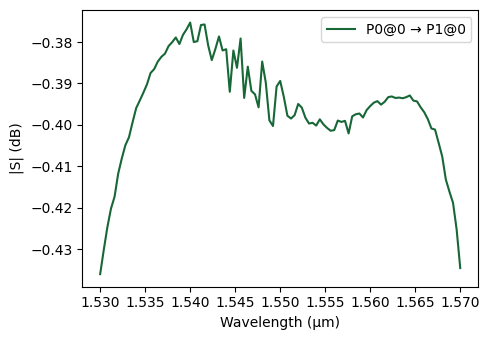

In [5]:
s_matrix = alice_top.s_matrix(freqs, model_kwargs={"inputs": ["P0@0"]})
fig, ax = pf.plot_s_matrix(s_matrix, input_ports=["P0"], output_ports=["P1", "P2", "P3", "P4"], y="dB")

c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'GND' at (175.675, 40.6) from component 'alice_top' does not match any reference terminals and will be ignored.
  netlist = component.get_netlist()
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'V_BASE' at (25.675, 40.6) from component 'alice_top' does not match any reference terminals and will be ignored.
  netlist = component.get_netlist()
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'V_BIT' at (325.5, 40.6) from component 'alice_top' does not match any reference terminals and will be ignored.
  netlist = component.get_netlist()
c:\Users\irfan\AppData\Local\Programs\Python\Python313\Lib\site-packages\photonforge\circuit_base.py:211: RuntimeWarning: Terminal 'VN' at (134.65, 5) from compo

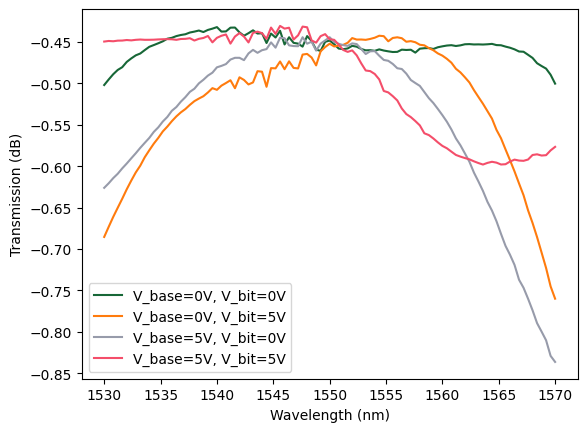

In [6]:
voltages = [0, 5]  # first is LOW voltage, second is HIGH voltage

fig, axs = plt.subplots()

for i in range(2):
    for j in range(2):
        updates = {("mzm_base", 0, "ps", 0): {"model_updates": {"voltage": voltages[i]}},
                    ("mzm_bit", 0, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_bit", 1, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_bit", 2, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_bit", 3, "ps", 0): {"model_updates": {"voltage": voltages[j]}},
                    ("mzm_base", 1, "ps", 0): {"model_updates": {"voltage": voltages[i]}},
                  }
        s_matrix = alice_top.s_matrix(freqs, model_kwargs={"updates": updates, "inputs": ["P0@0"]})
        s1 = s_matrix[("P0@0", "P1@0")]
        axs.plot(
            wavelengths * 1e3,
            10*np.log(np.abs(s1)),
            label=f"V_base={voltages[i]}V, V_bit={voltages[j]}V",
            linewidth=1.5,
        )

axs.set_xlabel("Wavelength (nm)")
axs.set_ylabel("Transmission (dB)")
axs.legend()

plt.show()
